# Hotel Reviews Data Analysis
##### By: Tom Allen
##### 1/24/2020

This analysis explores 10,000 hotel reviews in the United States from December 2018 to May 2019 provided by [Datafiniti's Business Database](https://datafiniti.co/products/business-data/). 


### Import Common Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Import the Dataset

In [2]:
df = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv')

In [3]:
df.head(1)

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,...,2018-01-03T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...


## Cleaning the Dataset

### Filtering Important Columns
Many of the columns are not important to this analysis, so I grab the relevant ones. 

In [4]:
cols = ['id','city','name','province','reviews.rating','reviews.text']
df = df[cols]

### Rename Column Names

In [5]:
df.rename(columns = {'reviews.rating':'rating'}, inplace = True)
df.rename(columns = {'reviews.text' : 'review'}, inplace = True)
df.rename(columns = {'province':'state'}, inplace = True)
df.rename(columns = {'name':'hotel'}, inplace = True)

### Count per Rating
Interesting there were so many 5-star ratings. Usually, you would think someone would post a rating if they only had a bad experience. 

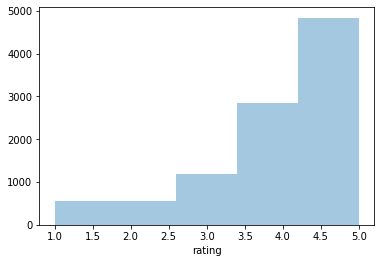

In [6]:
sns.distplot(df['rating'], kde = False, bins = 5)

The average rating is a 4.08, so I create a new column that will be used to classify if a reviewer liked (True) the hotel or not (False). 'Liked' in this case will be a rating of a 4 or 5, since it seems the reviewers tended to give higher ratings altogether. 

In [7]:
df['rating'].mean()

4.0841

In [8]:
df['liked'] = df['rating']>3

In [9]:
df.head(1)

,id,city,hotel,state,rating,review,liked
0,AWE2FvX5RxPSIh2RscTK,Goleta,Best Western Plus South Coast Inn,CA,3,"This hotel was nice and quiet. Did not know, t...",False


## Average Hotel Ratings per State

Creates a DataFrame that groups the data by state and grabs the average hotel rating for that state. __May only be able to view if copied and ran in a Jupyter Notebook__. 

In [10]:
avg_state_rat = pd.DataFrame(df.groupby('state')['rating'].mean()).reset_index()

Imports the necessary packages to plot the [choropleth map](https://plot.ly/python/reference/#choropleth).

In [11]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Creates the underlying data that will be passed into the __go.Figure__ function that creates the choropleth map. This will make the map based on U.S. states with the average rating as the value to be displayed. 

In [12]:
ratings_state = dict(type = 'choropleth', colorscale = 'fall', locations = avg_state_rat['state'], z = avg_state_rat['rating'],
                    locationmode = 'USA-states', text = avg_state_rat['state'], colorbar = {'title':'Avg Rating'}) 

Creates the layout of the chorpleth map to be visualized.

In [13]:
layout = dict(title = 'Average Hotel Ratings by State', geo = dict(scope = 'usa', showlakes = True, lakecolor = 'rgb(85,173,240)'))

In [14]:
choromap = go.Figure(data = [ratings_state], layout = layout)
iplot(choromap)

### Best and Worst Hotel Ratings

In [15]:
avg_state_rat.nlargest(3, 'rating')

,state,rating
28,NM,4.512821
0,AK,4.500000
40,UT,4.493976


In [16]:
avg_state_rat.nsmallest(3, 'rating')

,state,rating
35,RI,1.00
27,NJ,2.02
15,KY,3.60


## Natural Language Processing (NLP)
[Natural Language Processing](https://machinelearningmastery.com/natural-language-processing/) is a machine learning technique that programs computers to analyze human language and create some type of output or prediction.

### Import nltk
[nltk](http://www.nltk.org/book/) is the Natural Language Toolkit that has many libraries that can be used for Natural Language Processing.

In [17]:
#!conda install nltk 
import nltk 
#nltk.download() 

The string library contains a punctuation sub-library that can be iterated through to see if text has punctuation or not. This will be important to remove any punctuation as it won't be important in determining the significance it has to the rating. <br> <br>
The stopwords library contains any common words that aren't significant in predicting a review's rating such as 'the', 'an', 'a', etc.

In [18]:
import string
from nltk.corpus import stopwords

The __process_text__ function will take the review's text as input and go through the following steps:
1. Checks each character to see if it is punctuation ('.', ',', ':', etc.) and returns all non-punctuation characters in a list called 'no_punc'.
2. Joins all the characters back into the original word without the punctuation
3. Removes any stopwords that are considered non-significant to the rating

In [19]:
def process_text(review):
    no_punc = [char for char in review if char not in string.punctuation] # Step 1
    no_punc = ''.join(no_punc) # Step 2
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')] # Step 3

I then apply the __process_text__ function to all the review's. Notice they are not in sentence format, because I want to use the bag-of-words approach (i.e. each word will be a seperate column with a number (if present in the review) or 0 if it isn't). This will allow the algorithm to easily use the vectors to predict. 

In [20]:
df['review'].apply(process_text)

0       [hotel, nice, quiet, know, train, track, near,...
1       [stayed, king, suite, separation, bedroom, liv...
2       [Parking, horrible, somebody, ran, rental, car...
3       [cheap, excellent, location, Price, somewhat, ...
4       [get, room, advertised, website, paid, may, lu...
                              ...                        
9995    [friends, took, trip, Hampton, Basslights, sho...
9996    [check, departure, staff, friendly, profession...
9997    [Hampton, located, quiet, street, across, hosp...
9998    [Awesome, wings, favorite, garlic, parmesan, g...
9999    [Clean, facility, freeway, staff, friendly, ef...
Name: review, Length: 10000, dtype: object

### Vectorizing the List of Reviews
Using the [CountVectorizer model](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), this will convert the reviews into a matrix of counts of the frequency a word appears in each review and the location of the column the word is located in. 

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

The [Bag-of_Words](https://en.wikipedia.org/wiki/Bag-of-words_model) (bow_transformer) will transform the reviews into the matrix explained above. The analyzer will be the __process_text__ function that is used to clean the review into the format we need. 

In [22]:
bow_transformer = CountVectorizer(analyzer=process_text).fit(df['review'])

Let's look at the first review in regular sentence format. 

In [23]:
first_review = df['review'][0]
print(first_review)

This hotel was nice and quiet. Did not know, there was train track near by. But it was only few train passed during our stay. Best Western changed hotel classification. The Plus category are not the same as before.


Now let's see how its vectorized format looks with the frequency of each word. 

In [24]:
first_bow = bow_transformer.transform([first_review])
print(first_bow)

  (0, 2306)	1
  (0, 8428)	1
  (0, 11226)	1
  (0, 14969)	1
  (0, 15135)	1
  (0, 15475)	1
  (0, 22055)	2
  (0, 23535)	1
  (0, 25538)	1
  (0, 25708)	1
  (0, 27017)	1
  (0, 28554)	1
  (0, 32183)	1
  (0, 33973)	1
  (0, 34000)	2


Looks like the words 'hotel' and 'train' were used twice in the first review. 

In [25]:
print(bow_transformer.get_feature_names()[22055])
print(bow_transformer.get_feature_names()[34000])

hotel
train


Now I apply the Bag-of_Words transformer to __all__ the reviews that will be stored in __reviews_bow__.

In [26]:
reviews_bow = bow_transformer.transform(df['review'])

### Using TF-IDF
[TF-IDF](https://www.onely.com/blog/what-is-tf-idf/) stands for Term Frequency-Inverse Document Frequency which will essentially be used to weigh or measure how important a word is in each review.<br><br>
__TF__: Frequency of a word in the review (Ex: In the first review, 'hotel' and 'train' appear twice and a few other words appear once).
1. Formula: (number of time words appears in review)/(total number of words in the review)

__IDF__: Measures how important each word is (Ex: If 'hotel' or 'train' were to be highly frequent in all of the reveiws, it may indicate that these words may not be that significant to predicting the rating).
1. Formula: log_e(total number of reviews)/(number of reviews with the word in it)<br>

__TF-IDF__: Takes the frequency of each word in the review and offsets it by the frequncy it appears in the entire corpus of reviews.
1. Formula: TF * IDF

### Using the TF-IDF Transformer
This will be used to get the TF-IDF for all the words in each review.

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(reviews_bow)

Let's see the first review's TF-IDF weighting for each word.

In [28]:
first_tfidf = tfidf_transformer.transform(first_bow)
print(first_tfidf)

  (0, 34000)	0.4919288692009714
  (0, 33973)	0.30643657054757567
  (0, 32183)	0.07673544822372733
  (0, 28554)	0.15568073434350974
  (0, 27017)	0.2783477350665505
  (0, 25708)	0.10616972638007127
  (0, 25538)	0.16913900380966182
  (0, 23535)	0.15377419608848822
  (0, 22055)	0.1417213519976978
  (0, 15475)	0.42830703666050185
  (0, 15135)	0.2500584403203727
  (0, 14969)	0.32248802397001336
  (0, 11226)	0.18941890295043648
  (0, 8428)	0.23711187520582597
  (0, 2306)	0.17553531498280567


Looks like the word's 'train' and 'classification' had higher weight, therefore are more rare, than the word 'stay' which makes sense since most reviewers may talk about their 'stay' at the hotel. 

In [29]:
print(bow_transformer.get_feature_names()[34000])
print(bow_transformer.get_feature_names()[15475])
print(bow_transformer.get_feature_names()[32183])

train
classification
stay


Now we apply the tf-idf transformer to all the reviews. 

In [30]:
reviews_tfidf = tfidf_transformer.transform(reviews_bow)

### Using the Naive Bayes Classifier
The [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier will be used as the algorithm to predict if a review is classified as 'liked' or not. 'Liked' in this case is a rating of a 4 or 5.

In [31]:
from sklearn.naive_bayes import MultinomialNB
liked_hotel = MultinomialNB().fit(reviews_tfidf, df['liked'])

### Splitting the Data into Traning and Testing Sets
We will train the liked_hotel model on 80% of the dataset and will use the rest as test data to make the predictions.

In [32]:
from sklearn.model_selection import train_test_split
review_train, review_test, liked_train, liked_test = train_test_split(df['review'], df['liked'], test_size=0.2)

### Creating a Data Pipeline
This [pipeline](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) will allow us to easily pass in any data and perform the same steps above for future use instead of manually doing each step with different datasets. The steps are as follows:
1. Create the Bag-of_Words which converts each review as a vector with the frequency of each word
2. Weighs each word using the TF-IDF calculation
3. Trains the Naive Bayes classifier on the TF-IDF vectors

In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()),])

### Using the Data Pipeline
Passes the training data through the pipeline in order to analyze the results.

In [34]:
pipeline.fit(review_train, liked_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x1a202e9680>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Predictions
Predicts if a reviewer likes the hotel or not based on the sentiment of the review.

In [35]:
predictions = pipeline.predict(review_test)

### Evaluating the Predictions
Using a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), we can see the accuracy of this model is 77.1%
1. Calculation  = (True Positive + True Negative)/Total
2. 1542/2000 = 0.771
Overall, the model was good at predicting if the reviewer liked the hotel or not based on their reviews sentiment.

In [36]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(liked_test, predictions))

[[  25  476]
 [   0 1499]]


### Testing a Fake Review

In [37]:
fake_review = pd.Series('This hotel was up to my standards. The service was quick and the bed was comfy')
pred = pipeline.predict(fake_review)
pred

array([ True])

## Conclusion

This was my first time using Natural Language Processing for machine learning in Python, and I definitley had to use a lot of different resources throughout the process. One thing that could have swayed the model was if sarcasm was used as it wouldn't have been able to detect it and predict the opposite result. Overall, this was a fun dataset to work with and was good practice to manipulate and clean the data into the format the Natural Lanugage Processing model could understand. 